In [1]:
import numpy as np
import healpy as hp
import matplotlib.pylab as plt
%matplotlib inline
import sqlite3
import pandas as pd
from rubin_sim.scheduler.utils import EuclidOverlapFootprint
from rubin_sim.utils import ra_dec2_hpid, healbin
import os

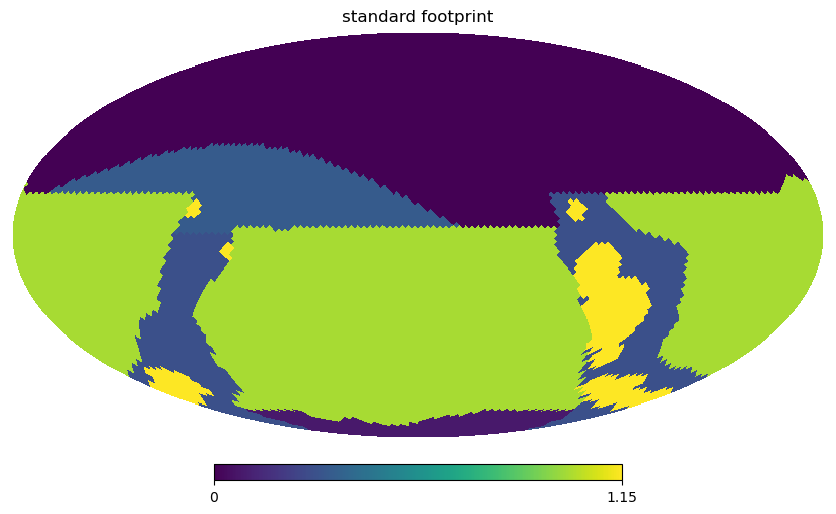

In [2]:
nside=32
sky = EuclidOverlapFootprint(nside=nside, smc_radius=4, lmc_radius=6)
footprints_hp_array, labels = sky.return_maps()
hp.mollview(footprints_hp_array["r"], title='standard footprint')

In [3]:
np.unique(labels)

good_hp = np.where((labels=="LMC_SMC") |  (labels=="duty_plane") |  
                   (labels=="lowdust") | (labels=="euclid_overlap") | (labels=="virgo"))[0]

In [4]:
np.unique(labels)

array(['', 'LMC_SMC', 'bulgy', 'dusty_plane', 'euclid_overlap', 'lowdust',
       'nes', 'scp', 'virgo'], dtype='<U20')

In [5]:
# Read the stars in
con = sqlite3.connect("msrgb_1e6.sqlite")
stars_df = pd.read_sql("select id,ra,decl,umag,gmag,rmag,imag,zmag,ymag from stars;" , con)
con.close()
# Repackage as numpy array
names = ['id', 'ra', 'decl', 'umag', 'gmag','rmag','imag','zmag','ymag',]
types = [int, float, float, float, float, float, float, float, float]
stars_in = np.empty(stars_df.shape[0], dtype=list(zip(names, types)))
for key in names:
    stars_in[key] = stars_df[key].values

In [6]:
def parse_name(infile):
    fn = os.path.basename(infile).replace('.npz', '')
    ack = fn.split('_')
    npatch = ack[-1]
    years = ack[-2]
    filtername = ack[-3]
    run_name = '_'.join(ack[:-3])
    return npatch,years,filtername,run_name

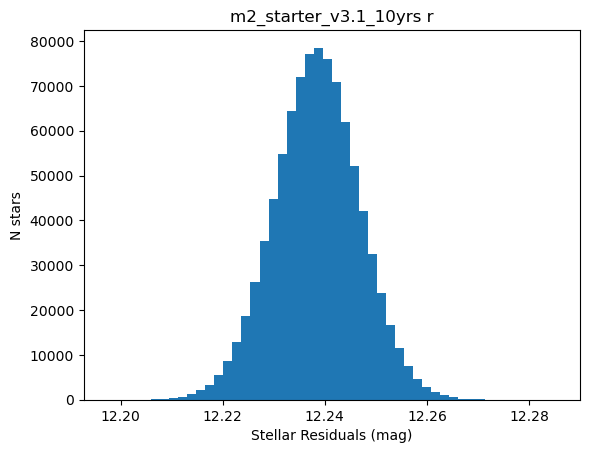

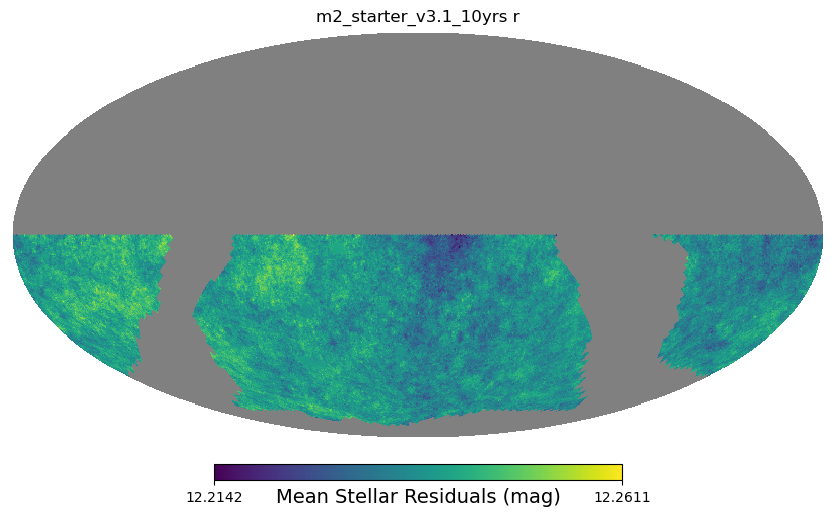

In [7]:
results = []

filename = 'm2_starter_v3.1_10yrs_r_1.0_16.npz'

npatch,years,filtername,run_name = parse_name(filename)
stars_out = np.load(filename)['fit_stars'].copy()

#stars_hp = ra_dec2_hpid(nside, stars_in["ra"][stars_out["id"]], stars_in["decl"][stars_out["id"]])

resid = stars_in[np.in1d(stars_in['id'], stars_out['id'])]["%smag" % filtername] - stars_out["fit_mag"]
# only look at residuals of stars that are in the WFD area

ra = stars_in["ra"][np.in1d(stars_in['id'], stars_out['id'])]
dec = stars_in["decl"][np.in1d(stars_in['id'], stars_out['id'])]
stars_hp = ra_dec2_hpid(32, ra, dec)
resid = resid[np.in1d(stars_hp, good_hp)]

ra = ra[np.in1d(stars_hp, good_hp)]
dec = dec[np.in1d(stars_hp, good_hp)]

fig, ax = plt.subplots()
ax.hist(resid, bins=50)
ax.set_title(run_name + ' '+filtername)
ax.set_xlabel('Stellar Residuals (mag)')
ax.set_ylabel('N stars')

std_iqr = (np.percentile(resid, 75) - np.percentile(resid, 25))/1.35
results.append([run_name, std_iqr, np.std(resid)])

resid_map = healbin(ra, dec, resid, nside=128, reduce_func=np.mean)
hp.mollview(resid_map,  title=run_name + ' '+filtername, unit='Mean Stellar Residuals (mag)')



In [8]:
results

[['m2_starter_v3.1_10yrs', 0.00818921623064739, 0.00831178109633915]]